In [18]:
import os, sys
import numpy as np
import ccdproc as ccdp
from tqdm import tqdm_notebook
from astropy.io import fits
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/veloce_reduction')
from veloce_reduction.calibration import crop_overscan_region
from veloce_reduction.calibration import correct_for_bias_and_dark_from_filename
gain = [0.88,0.93,0.99,0.93]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = '/Users/arcticfox/Documents/youngStars/veloce/spectra/fitsfiles'
outpath = '/Users/arcticfox/Documents/youngStars/veloce/spectra/extracted'

In [3]:
science_frames = np.loadtxt(os.path.join(path,'itsfiles_stellar_list.txt'), dtype='U32')

In [19]:
date = '08nov'
stripe_masks = np.load(os.path.join(path,'{0}_stripe_masks.npy'.format(date)), 
                       allow_pickle=True).item()
frames = np.sort([os.path.join(path, i) for i in science_frames if date in i])
bias = fits.open(os.path.join(path, '{0}_master_bias.fits'.format(date)))[0].data+0.0
readnoise = fits.open(os.path.join(path, '{0}_read_noise_mask.fits'.format(date)))[0].data + 0.0

bias = crop_overscan_region(bias)
readnoise = crop_overscan_region(readnoise)

order_keys = sorted(stripe_masks.keys())

In [ ]:
new_files = []

for i in tqdm_notebook(range(len(frames))):
    hdu = fits.open(frames[i])

    if 'TIC' in hdu[0].header['OBJECT']:
        outfn = frames[i].split('/')[-1][:-5]+'_spectra.npy'
        #data = crop_overscan_region(hdu[0].data + 0.0)

        spectra = {}
        
        exptime = int(hdu[0].header['EXPOSED'])
        dark =  fits.open(os.path.join(path,
                                       '{0}_master_dark_t{1}.fits'.format(date, exptime)))[0].data
        
        pipeline_corrected = correct_for_bias_and_dark_from_filename(frames[i],
                                                                     MB=bias,
                                                                     MD=dark,
                                                                     gain=gain,
                                                                     path=path)
        removed_crs = ccdp.cosmicray_lacosmic(pipeline_corrected, sigclip=5)

        for key in order_keys:
            spectra[key] = np.nansum(removed_crs[0]*stripe_masks[key], axis=0)

        np.save(os.path.join(outpath, outfn), spectra)
        new_files.append(os.path.join(outpath, outfn))
    hdu.close()   

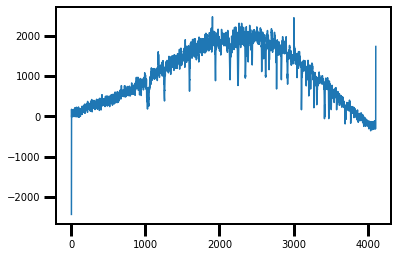

In [17]:
plt.plot(spectra['order_30'])